In [ ]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Prepare your comparison patterns
We stopped at the step of OCR in phase 1. Now, it's time to proceed. There are many methods to perform OCR, some classical, some modern. We'll do a classical approach using morphological operations and "gold" reference digit structuring elements. By seeing how well each tile matches each of the digits, we could detect the value in each tile. Note that I crafted these SEs by hand to give good results.

You see what you can do.

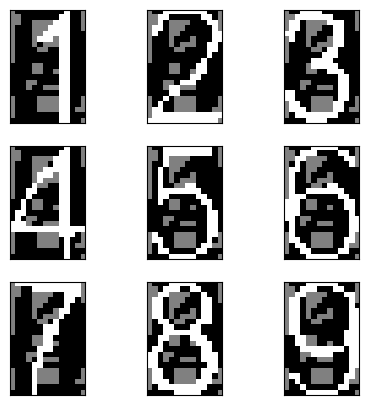

In [ ]:
digit_ses = []
for i in range(9):
    se = cv2.imread(f"{i+1}.jpg", cv2.IMREAD_GRAYSCALE)
    se_canvas = np.zeros_like(se, dtype = np.int16)
    se_canvas[se < 64] = -1
    se_canvas[se > 192] = 1
    digit_ses.append(se_canvas)
_, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(digit_ses[i*3+j], cmap="gray", vmin=-1, vmax=1);
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

# Phase 1 speedrun
Since I'm too lazy to get the output from phase 1 here, I will just write this big block of code to recreate the output

In [ ]:
req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1)
imgg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imggt = cv2.adaptiveThreshold(imgg,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,111,5)
m = min(img.shape[0],img.shape[1])/2
lines = cv2.HoughLinesP(imggt,rho=1,theta=np.pi/180,threshold=200,minLineLength=m,maxLineGap=17)

def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    return (int(nx / d), int(ny / d))

def point_on_line(point, line):
    def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
    diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
    return np.abs(diff) < 75

intersections = []
num_of_lines = len(lines[:,0])
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = lines[i,0]
        line2 = lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if point_on_line(p, line1) and point_on_line(p, line2):
            intersections.append(p[::-1])

p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])

y, x = imgg.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32(coords)
imgtw = cv2.warpPerspective(imggt,cv2.getPerspectiveTransform(dst_coords, src_coords),(x, y))

M = img.shape[0] // 9
N = img.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = imgtw[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

# Time for OCR!

First, let's display the number tiles (thresholded) obtained from the image.

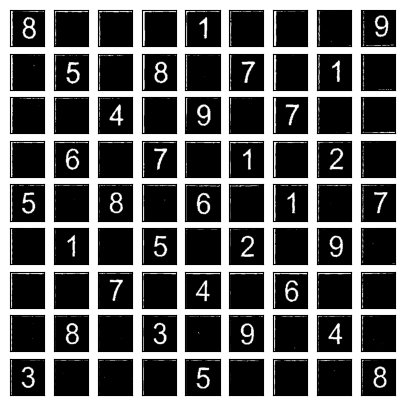

In [ ]:
tiles = [cv2.threshold(number_tiles[t//9][t%9], 250, 255, cv2.THRESH_BINARY)[1] for t in range(9*9)]
_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(tiles[i*9 + j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)

Ok, so what do we do now? Let's try and see how "similar" each tile is to the corresponding structuring elements.

The gray areas (value=0) don't matter, the white areas (value=1) give you positive score if they are white in the tile, and the black areas (value=-1) give you negative score if they are black in the tile.

In [ ]:
# This method will tell me if the digit exists in the image or not
# But it won't tell me where; if exists
def se_match(se, image):
    se_height, se_width = se.shape
    MAX_SCORE = np.sum(se == 1) * 4  # Total number of value=1 pixels
    score = 0
    # Go over all windows in image and get the maximum score obtained
    for y in range(image.shape[0] - se_height):
        for x in range(image.shape[1] - se_width):
            window = image[y:y+se_height, x:x+se_width]
            temp_score = np.sum((window == 255) & (se == 1)) * 4  # Higher weight on white-matches
            temp_score -= np.sum((window == 0) & (se == -1))
            score = max(score, temp_score)
    return max(0, score/MAX_SCORE)

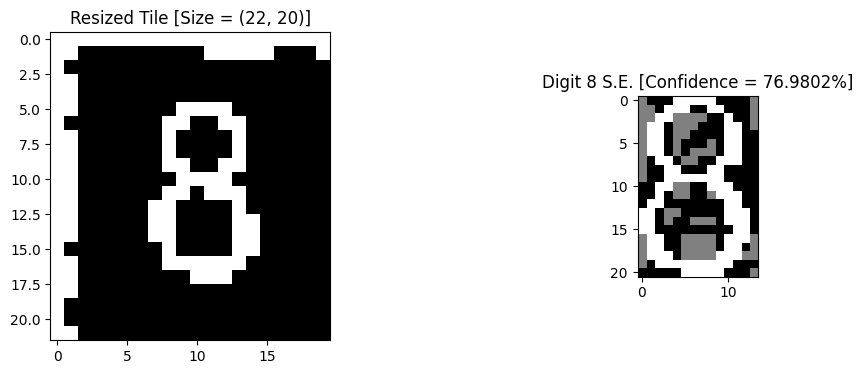

In [ ]:
fig = plt.figure(figsize=(12, 4))
gs = plt.GridSpec(5, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[1:4, 1])

tile = tiles[0]  # First tile whose value is 8
se = digit_ses[7]  # S.E. for digit 8

max_confidence = -100
max_confidence_se = None

# To obtain scale-invariance, let's try different input sizes
for h in range(tile.shape[0], se.shape[0], -1):
    y, x = tile.shape
    resized_tile = cv2.resize(tile, ((h*x)//y, h), cv2.INTER_NEAREST)
    resized_tile = cv2.threshold(resized_tile, 1, 255, cv2.THRESH_BINARY)[1]
    confidence = se_match(se, resized_tile)
    if confidence >= max_confidence:
        max_confidence = confidence
        max_confidence_se = se

ax1.imshow(resized_tile, cmap="gray");
ax1.set_title(f"Resized Tile [Size = {resized_tile.shape}]");
ax2.imshow(max_confidence_se, cmap="gray", vmin=-1, vmax=1);
ax2.set_title(f"Digit 8 S.E. [Confidence = {round(100*max_confidence, 4)}%]");

One more thing... How about, to improve performance, we precompute all the different sizes of the input tiles?

In [ ]:
sitiles = []  # Scale-invariant tiles
y, x = tiles[0].shape
for i, tile in enumerate(tiles):
    sitiles.append([])
    for h in range(y//2, digit_ses[0].shape[0], -1):
        resized_tile = cv2.resize(tile, ((h*x)//y, h), cv2.INTER_NEAREST)
        resized_tile = cv2.threshold(resized_tile, 1, 255, cv2.THRESH_BINARY)[1]
        sitiles[i].append(resized_tile)

For even MORE performance, we'll need to parallelize our loop

In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

Great... Let's do this for all tiles then!

In [ ]:
sudoku_ocr = np.zeros((9*9,))

def ocr_progress(init=False):
    if init: ocr_progress.value = 0
    else: ocr_progress.value += 1
    print(f"\r[{u'█'*ocr_progress.value}{('-'*(9*9-ocr_progress.value))}] {ocr_progress.value}/{9*9} tiles processed.", end='')

async def ocr(tileno, min_confidence):
    max_confidence = -100
    max_confidence_se = None
    max_confidence_se_i = -1
    ax1 = fig.add_subplot(gs[tileno*7+1:(tileno+1)*7-1, 0]);
    ax1.set_title(f"Tile [{tileno//9}][{tileno%9}]");
    ax1.imshow(tiles[tileno], cmap="gray");
    for tile in sitiles[tileno]:
        for se_i, se in enumerate(digit_ses):
            confidence = se_match(se, tile)
            if confidence > max_confidence:
                max_confidence = confidence
                max_confidence_se = se
                max_confidence_se_i = se_i
    if (max_confidence >= min_confidence):
        ax2 = fig.add_subplot(gs[tileno*7+2:(tileno+1)*7-2, 2]);
        ax2.set_title(f"S.E. [Confidence = {round(max_confidence*100, 4)}%]");
        ax2.imshow(max_confidence_se, cmap="gray");
        sudoku_ocr[tileno] = max_confidence_se_i + 1
    ocr_progress()

[█████████████████████████████████████████████████████████████████████████████████] 81/81 tiles processed.

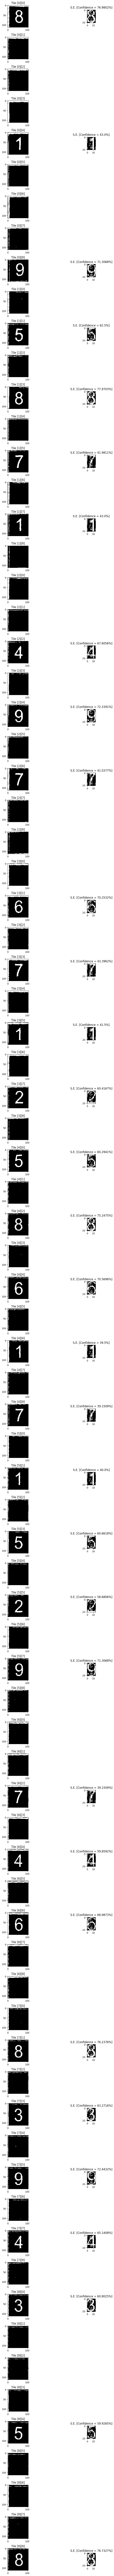

In [ ]:
fig = plt.figure(figsize=(8, 200))
gs = plt.GridSpec(7*9*9, 3)
ocr_progress(init=True)  # Initial progress (0 tiles processed)
await asyncio.wait(
    [asyncio.create_task(ocr(tileno, 0.33)) for tileno in range(9*9)]
);

(tbh I don't believe this even worked lol)

# Et voila!

In [ ]:
def textize_sudoku(board):
    sudoku_ocr_text = ''
    for i, row in enumerate(board):
        sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ ' if (i%3 == 0) else ' │           │           │           │ '
        sudoku_ocr_text += '\n'
        sudoku_ocr_text += ' │ '
        for j, cell in enumerate(row): sudoku_ocr_text += f"{cell if cell != 0 else ' '} {' ' if (j%3 != 2) else '│'} "
        sudoku_ocr_text += '\n'
    sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ '
    return sudoku_ocr_text

In [ ]:
def find_next_empty_cell(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)
    return None

def is_valid(board, num, row, col):
    for i in range(9):  # row and column checks
        if board[row][i] == num and col != i: return False
        if board[i][col] == num and row != i: return False

    # Check box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3
    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if board[i][j] == num and (i, j) != (row, col):
                return False
    return True

def solve(board):
    empty_cell_pos = find_next_empty_cell(board)
    if empty_cell_pos == None: return True  # No empty cells; board is solved
    row, col = empty_cell_pos
    for num in range(1, 10):
        if is_valid(board, num, row, col):  # Find a valid value to proceed with
            board[row][col] = num  # 'num' seems valid (so far), proceed with it
            if solve(board): return True  # Try to solve the rest of the board
            board[row][col] = 0  # Couldn't continue? Then 'num' was wrong! :(
    return False

def solve_sudoku(board):
    sudoku_to_solve = np.copy(board)
    solve(sudoku_to_solve)
    solved_sudoku = []
    for i in range(9):
        solved_sudoku.append([])
        for j in range(9):
            solved_sudoku[i].append("\033[1m"+str(board[i][j])+"\033[0m" if (board[i][j] != 0) else "\033[91m"+str(sudoku_to_solve[i][j])+"\033[0m")
    return solved_sudoku

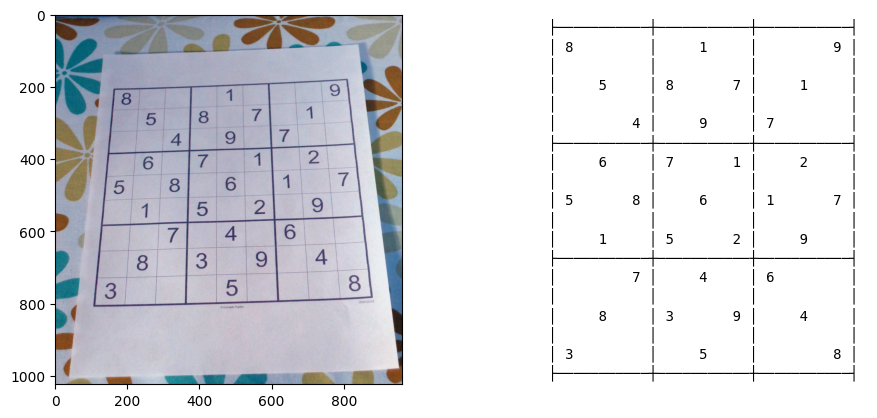

In [ ]:
plt.imshow(img);
plt.figtext(1, 0.125, textize_sudoku(sudoku_ocr.reshape((9, 9)).astype(int)), fontfamily='monospace');

In [ ]:
print(textize_sudoku(solve_sudoku(sudoku_ocr.reshape((9, 9)).astype(int))))

 ├───────────┼───────────┼───────────┤ 
 │ 8   7   2 │ 4   1   3 │ 5   6   9 │ 
 │           │           │           │ 
 │ 9   5   6 │ 8   2   7 │ 3   1   4 │ 
 │           │           │           │ 
 │ 1   3   4 │ 6   9   5 │ 7   8   2 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 4   6   9 │ 7   3   1 │ 8   2   5 │ 
 │           │           │           │ 
 │ 5   2   8 │ 9   6   4 │ 1   3   7 │ 
 │           │           │           │ 
 │ 7   1   3 │ 5   8   2 │ 4   9   6 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 2   9   7 │ 1   4   8 │ 6   5   3 │ 
 │           │           │           │ 
 │ 6   8   5 │ 3   7   9 │ 2   4   1 │ 
 │           │           │           │ 
 │ 3   4   1 │ 2   5   6 │ 9   7   8 │ 
 ├───────────┼───────────┼───────────┤ 
